<table> 
    <tr>
        <td  style="background-color:#ffffff;"><a href="https://qsoftware.lu.lv/index.php/qworld/" target="_blank"><img src="..\Images\qworld.jpg" width="70%" align="left"></a></td>
        <td style="background-color:#ffffff;" width="*"></td>
        <td  style="background-color:#ffffff;vertical-align:text-top;"><a href="https://qsoftware.lu.lv" target="_blank"><img src="..\Images\qturkey.png" width="50%" align="right"></a></td>        
    </tr></table>
<table><tr style="background-color:white;">
    <td>Follow Us (QWorld)</td>
    <td><a href="https://www.facebook.com/qworld19/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/QWorld19" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td>Follow QLatvia</td>
    <td><a href="https://www.facebook.com/QLatviaSoftware/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/QLatviaSoftware" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td>Follow QTurkey</td>
    <td><a href="https://www.facebook.com/groups/290363815207623/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/KuantumTurkiye" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    </tr></table>

# Deep Convolutional Generative Adversarial Network

[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

<img src="../Images/gan1.png" />

During training, the *generator* progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

<img src="../Images/gan2.png" />

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the generator as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

<img src="../Images/dcgan.gif" />

To learn more about GANs, also Deep Learning you can check MIT's [Intro to Deep Learning course](http://introtodeeplearning.com/).

## Import TensorFlow and other libraries

In [34]:
import tensorflow as tf
import glob
import imageio # To generate GIFs
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Load and prepare the dataset
You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [35]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [36]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models
Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator
The generator uses [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the [tf.keras.layers.LeakyReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer, except the output layer which uses tanh.

In [37]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

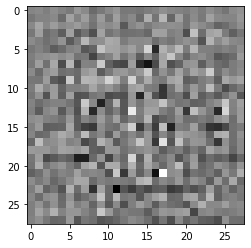

In [38]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator
The discriminator is a CNN-based image classifier.

In [39]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [40]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00194948]], shape=(1, 1), dtype=float32)


### Define the loss and optimizers
Define loss functions and optimizers for both models.

In [41]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [42]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [43]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [44]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define the training loop

In [46]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [47]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [48]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### Generate and save images

In [50]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

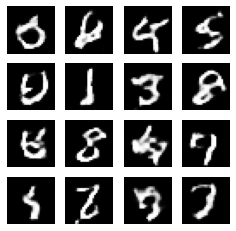

In [51]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [52]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Create a GIF

In [53]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

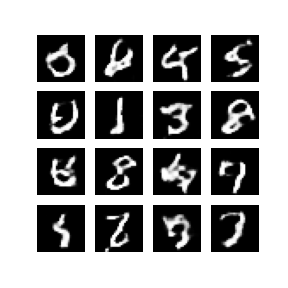

In [54]:
display_image(EPOCHS)

Use imageio to create an animated gif using the images saved during training.

In [55]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

# Quantum Generative Adversarial Networks with Cirq + TensorFlow
This demo constructs a Quantum Generative Adversarial Network (QGAN) ([Lloyd and Weedbrook (2018), Dallaire-Demers and Killoran (2018)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.040502)) using two subcircuits, a generator and a discriminator. The generator attempts to generate synthetic quantum data to match a pattern of “real” data, while the discriminator tries to discern real data from fake data (see image below). The gradient of the discriminator’s output provides a training signal for the generator to improve its fake generated data
<img src="../Images/qgan.png" />

## Using Cirq + TensorFlow
PennyLane allows us to mix and match quantum devices and classical machine learning software. For this demo, we will link together Google’s [Cirq](https://cirq.readthedocs.io/en/stable/) and [TensorFlow](https://www.tensorflow.org/) libraries.

We begin by importing PennyLane, NumPy, and TensorFlow. We also declare a 3-qubit simulator device running in Cirq.

In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf

dev  = qml.device('cirq.simulator', wires=3)

## Generator and Discriminator
In classical GANs, the starting point is to draw samples either from some “real data” distribution, or from the generator, and feed them to the discriminator. In this QGAN example, we will use a quantum circuit to generate the real data.

For this simple example, our real data will be a qubit that has been rotated (from the starting state 
|
0
⟩
) to some arbitrary, but fixed, state.

In [2]:
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

For the generator and discriminator, we will choose the same basic circuit structure, but acting on different wires.

Both the real data circuit and the generator will output on wire 0, which will be connected as an input to the discriminator. Wire 1 is provided as a workspace for the generator, while the discriminator’s output will be on wire 2.

In [3]:
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)


def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

We create two QNodes. One where the real data source is wired up to the discriminator, and one where the generator is connected to the discriminator. In order to pass TensorFlow Variables into the quantum circuits, we specify the "tf" interface.

In [5]:
@qml.qnode(dev, interface="tf")
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev, interface="tf")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

## QGAN cost functions
There are two cost functions of interest, corresponding to the two stages of QGAN training. These cost functions are built from two pieces: the first piece is the probability that the discriminator correctly classifies real data as real. The second piece is the probability that the discriminator classifies fake data (i.e., a state prepared by the generator) as real.

The discriminator is trained to maximize the probability of correctly classifying real data, while minimizing the probability of mistakenly classifying fake data.

The generator is trained to maximize the probability that the discriminator accepts fake data as real.

In [6]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

## Training the QGAN
We initialize the fixed angles of the “real data” circuit, as well as the initial parameters for both generator and discriminator. These are chosen so that the generator initially prepares a state on wire 0 that is very close to the |1⟩ state.

In [7]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

We begin by creating the optimizer:

In [8]:
opt = tf.keras.optimizers.SGD(0.1)

In the first stage of training, we optimize the discriminator while keeping the generator parameters fixed.

In [9]:
cost = lambda: disc_cost(disc_weights)

for step in range(50):
    opt.minimize(cost, disc_weights)
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.03117436170578003
Step 5: cost = -0.07601916044950485
Step 10: cost = -0.1250053346157074
Step 15: cost = -0.17878097295761108
Step 20: cost = -0.23552672564983368
Step 25: cost = -0.29119202494621277
Step 30: cost = -0.3410956412553787
Step 35: cost = -0.38198623061180115
Step 40: cost = -0.4130288437008858
Step 45: cost = -0.4353272318840027


At the discriminator’s optimum, the probability for the discriminator to correctly classify the real data should be close to one.

In [11]:
print("Prob(real classified as real): ", prob_real_true(disc_weights).numpy())

Prob(real classified as real):  0.9288134947419167


For comparison, we check how the discriminator classifies the generator’s (still unoptimized) fake data:

In [12]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.4806368052959442


In the adversarial game we now have to train the generator to better fool the discriminator. For this demo, we only perform one stage of the game. For more complex models, we would continue training the models in an alternating fashion until we reach the optimum point of the two-player adversarial game.

In [13]:
cost = lambda: gen_cost(gen_weights)

for step in range(50):
    opt.minimize(cost, gen_weights)
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.502943366765976
Step 5: cost = -0.61121866106987
Step 10: cost = -0.7063378989696503
Step 15: cost = -0.7820403575897217
Step 20: cost = -0.8376968801021576
Step 25: cost = -0.8763851188123226
Step 30: cost = -0.9023893624544144
Step 35: cost = -0.9196043685078621
Step 40: cost = -0.9309796988964081
Step 45: cost = -0.9385456740856171


At the optimum of the generator, the probability for the discriminator to be fooled should be close to 1.

In [14]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.9427673909813166


At the joint optimum the discriminator cost will be close to zero, indicating that the discriminator assigns equal probability to both real and generated data.

In [15]:
print("Discriminator cost: ", disc_cost(disc_weights).numpy())

Discriminator cost:  0.01395389623939991


The generator has successfully learned how to simulate the real data enough to fool the discriminator.

Let’s conclude by comparing the states of the real data circuit and the generator. We expect the generator to have learned to be in a state that is very close to the one prepared in the real data circuit. An easy way to access the state of the first qubit is through its Bloch sphere representation:

In [16]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_generator = qml.map(generator, obs, dev, interface="tf")

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights)))

Real Bloch vector: [-0.2169418   0.45048445 -0.86602525]
Generator Bloch vector: [-0.18812191  0.10874844 -0.95227164]


#### References
- [Generative Adveserial Networks with Tensorflow](https://www.tensorflow.org/tutorials/generative/dcgan)
- [PennyLane QGAN Tutorial](https://pennylane.ai/qml/demos/tutorial_QGAN.html)